In [11]:
from Bio.PDB import PDBList, is_aa, NeighborSearch, PDBIO
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBIO import Select
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from Bio.SeqUtils import seq1, IUPACData

import numpy as np


PDB_ID = "1d9n"
PATH = "./pdb/"

ImportError: cannot import name 'IUPACData' from 'Bio.PDB' (C:\Users\Marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\Bio\PDB\__init__.py)

In [2]:
#Print PDB structure
parser = PDBParser(QUIET=True)
structure = parser.get_structure(PDB_ID, PATH + "/pdb{}.ent".format(PDB_ID))

class ChainSelect(Select):
    def accept_chain(self, chain):
        if chain.id == "A":
            return 1
        else:
            return 0
    def accept_residue(self, residue):
        if is_aa(residue):
            return 1
        else:
            return 0
    def accept_atom(self, atom):
        return 1
    
io = PDBIO()
io.set_structure(structure)
io.save("1d9n_chainA.pdb", ChainSelect())


Structure exists: './pdb/pdb1d9n.ent' 
Chain len: 75
Atoms len: 1183
len(close_contacts): 265
len(new_close_contacts): 191
len(close_contacts) after cleaning: 191
Number of contacts:  382


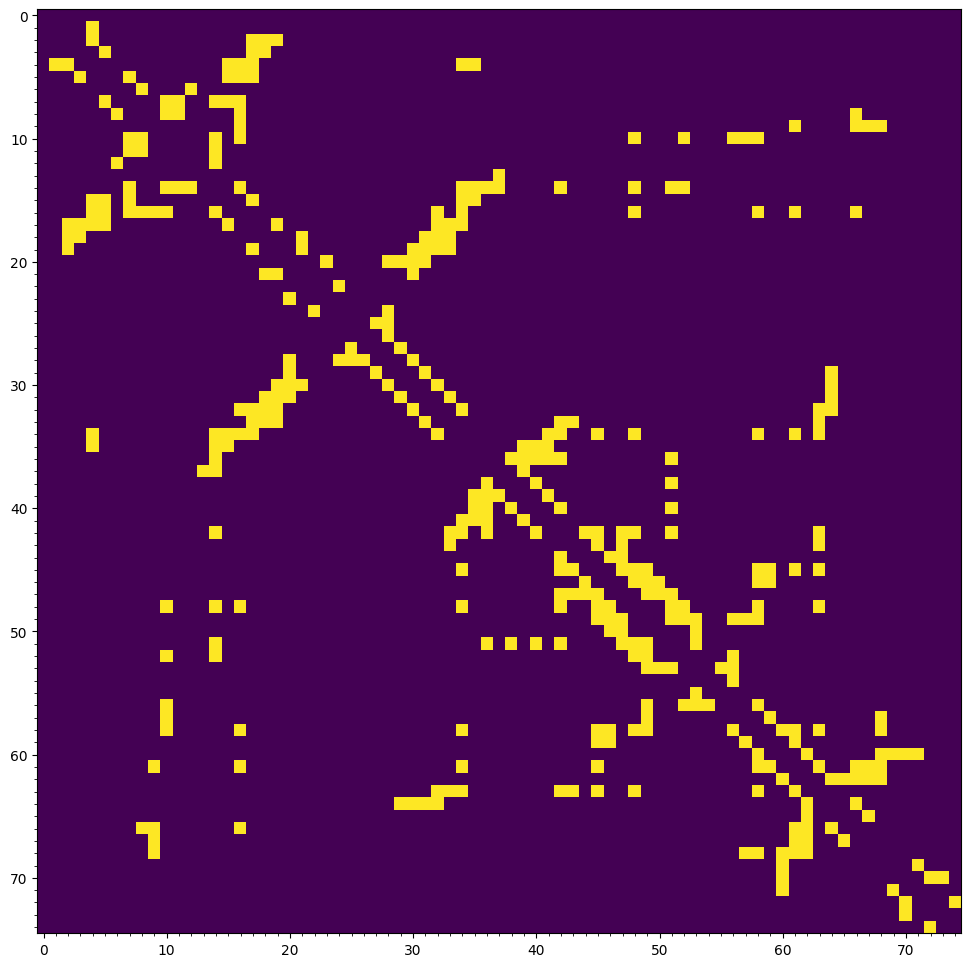

In [3]:
# Calculate and plot the contact map of your chain. Use the NeighborSearch module and the search_all(3.5, level=”R”) method. Consider only contacts between positions with a sequence separation ≥ 2.

pdbl = PDBList()
pdbl.retrieve_pdb_file(PDB_ID, pdir=PATH, file_format="pdb")

parser = PDBParser()
#structure = parser.get_structure(PDB_ID, PATH + "pdb"+PDB_ID + ".ent")
structure = parser.get_structure(PDB_ID, "1d9n_chainA.pdb")
# Extract the chain you're interested in
chain = structure[0]['A']  # Replace 'A' with the chain ID you're interested in
print("Chain len:", len(chain))
atoms = list(chain.get_atoms())
print("Atoms len:", len(atoms))
# Create NeighborSearch object
ns = NeighborSearch(atoms)

# Find all close contacts within a specified radius and return them as list of residue pairs
close_contacts = ns.search_all(3.5, level="R")
print("len(close_contacts):", len(close_contacts))
# Check if sequence separation is >= 2
new_close_contacts = []
for tup in close_contacts:
    #print("Res 1:", tup[0]['CA'].get_full_id()[3][1], "Res 2:", tup[1]['CA'].get_full_id()[3][1])
    #print("Res no CA: ", tup[0].get_full_id()[3][1], "Res no CA: ", tup[1].get_full_id()[3][1])
    if abs(tup[0]['CA'].get_full_id()[3][1] - tup[1]['CA'].get_full_id()[3][1]) >= 2:
        new_close_contacts.append(tup)
print("len(new_close_contacts):", len(new_close_contacts))
close_contacts = new_close_contacts
print("len(close_contacts) after cleaning:", len(close_contacts))

# Create a matrix with the contact map
seq_len = len(list(chain.get_residues()))
contact_map = np.zeros((seq_len, seq_len))
for tup in close_contacts:
    i = tup[0].get_full_id()[3][1] - 1
    j = tup[1].get_full_id()[3][1] - 1
    contact_map[i][j] = 1
    contact_map[j][i] = 1

 # Count 1 on the distance matrix
count = 0
for i in range(len(contact_map)):
    for j in range(len(contact_map)):
        if contact_map[i][j] == 1:
            count += 1

print("Number of contacts: ", count)

# Plot the contact map
# Plot contact map
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(contact_map)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(PATH + '/ca_contacts_{}.png'.format(PDB_ID), dpi=300, bbox_inches='tight')

In [4]:
# import aa_list, p_matrix, m_matrix
execfile("iupred_data.py")
m_matrix
aa_list

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [82]:
#Calculate the exact energy of each residue based on the weighted contribution of its contacts (as calculated above) and plot the raw and smoothed energy for each residue on the same figure. 
#Use the M matrix to calculate the contact energy.

In [5]:
def iupred(seq, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''

    pred = []  # Calculated energy per sequence position
    pred_smooth = []

    indices = [aa_list.index(aa) for aa in list(seq)]  # Transform sequence into indexes as in the P matrix
    for i, aa_index in enumerate(indices):

        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = max(0, i - window_size)
        end_before = max(0, i - sequence_separation)
        start_after = min(len(indices) - 1, i + sequence_separation)
        end_after = min(len(indices) - 1, i + window_size)
        indices_local = indices[start_before: end_before] + indices[start_after: end_after]
        print(i, aa_index, aa_list[aa_index], len(indices), len(indices_local), start_before, end_before, start_after, end_after)

        # Count the different amino acids in the window
        row = np.full((20,), 0)
        for index in indices_local:
            row[index] += 1
        print(row)

        # calculate AA frequency
        row = row / len(indices_local)
        print(row)

        # calculate energy
        row = row * p_matrix[aa_index]
        print(row)

        aa_energy = np.sum(row)
        print(i, seq[i], aa_energy)

        pred.append(aa_energy)

    # Smooth the prediction (moving average)
    for i in range(len(pred)):
        frag = pred[max(0, i - window_size_smooth): min(i + window_size_smooth, len(pred))]
        pred_smooth.append(sum(frag) / len(frag))

    return pred, pred_smooth

In [10]:
residues = [residue for residue in structure[0]["A"] if residue.id[0] == " "]
seq = "".join([seq1(residue.get_resname()) for residue in residues])

print(len(seq))
interactions = np.zeros((len(20), len(20)))
for i in range(len(seq)):
    for j in range(len(seq)):
        if contact_map[i][j] == 1:
            interactions[IUPACData.protein_letters.index(seq[i])][IUPACData.protein_letters.index(seq[j])] += 1

75
1 A 4 W
2 E 4 W
2 E 17 R
2 E 18 E
2 E 19 V
3 D 5 L
3 D 17 R
3 D 18 E
4 W 1 A
4 W 2 E
4 W 15 K
4 W 16 R
4 W 17 R
4 W 34 Y
4 W 35 Q
5 L 3 D
5 L 7 C
5 L 15 K
5 L 16 R
5 L 17 R
6 D 8 P
6 D 12 P
7 C 5 L
7 C 10 L
7 C 11 G
7 C 14 W
7 C 15 K
7 C 16 R
8 P 6 D
8 P 10 L
8 P 11 G
8 P 16 R
8 P 66 G
9 A 16 R
9 A 61 F
9 A 66 G
9 A 67 I
9 A 68 L
10 L 7 C
10 L 8 P
10 L 14 W
10 L 16 R
10 L 48 L
10 L 52 L
10 L 56 C
10 L 57 D
10 L 58 L
11 G 7 C
11 G 8 P
11 G 14 W
12 P 6 D
12 P 14 W
13 G 37 P
14 W 7 C
14 W 10 L
14 W 11 G
14 W 12 P
14 W 16 R
14 W 34 Y
14 W 35 Q
14 W 36 S
14 W 37 P
14 W 42 I
14 W 48 L
14 W 51 Y
14 W 52 L
15 K 4 W
15 K 5 L
15 K 7 C
15 K 17 R
15 K 34 Y
15 K 35 Q
16 R 4 W
16 R 5 L
16 R 7 C
16 R 8 P
16 R 9 A
16 R 10 L
16 R 14 W
16 R 32 T
16 R 34 Y
16 R 48 L
16 R 58 L
16 R 61 F
16 R 66 G
17 R 2 E
17 R 3 D
17 R 4 W
17 R 5 L
17 R 15 K
17 R 19 V
17 R 32 T
17 R 33 Y
17 R 34 Y
18 E 2 E
18 E 3 D
18 E 21 R
18 E 31 D
18 E 32 T
18 E 33 Y
19 V 2 E
19 V 17 R
19 V 21 R
19 V 30 S
19 V 31 D
19 V 32 T
19 V 3

0 10 M 75 72 0 0 2 74
[4 4 6 3 3 7 0 2 4 7 0 0 6 2 7 4 5 2 2 4]
[0.05555556 0.05555556 0.08333333 0.04166667 0.04166667 0.09722222
 0.         0.02777778 0.05555556 0.09722222 0.         0.
 0.08333333 0.02777778 0.09722222 0.05555556 0.06944444 0.02777778
 0.02777778 0.05555556]
[-0.11555556  0.07944444  0.05083333  0.10541667 -0.2225     -0.05055556
 -0.         -0.10055556  0.08944444 -0.28       -0.          0.
  0.0625      0.05277778  0.20319444  0.07722222  0.04375    -0.07194444
 -0.19111111 -0.54055556]
0 M -0.8081944444444444
1 0 A 75 71 0 0 3 74
[4 4 6 2 3 7 0 2 4 7 0 0 6 2 7 4 5 2 2 4]
[0.05633803 0.05633803 0.08450704 0.02816901 0.04225352 0.09859155
 0.         0.02816901 0.05633803 0.09859155 0.         0.
 0.08450704 0.02816901 0.09859155 0.05633803 0.07042254 0.02816901
 0.02816901 0.05633803]
[-0.09295775 -0.15943662  0.09802817  0.05070423 -0.15760563 -0.04042254
  0.         -0.10394366  0.02760563 -0.29676056 -0.          0.
  0.13014085  0.03380282  0.09661972 -0.

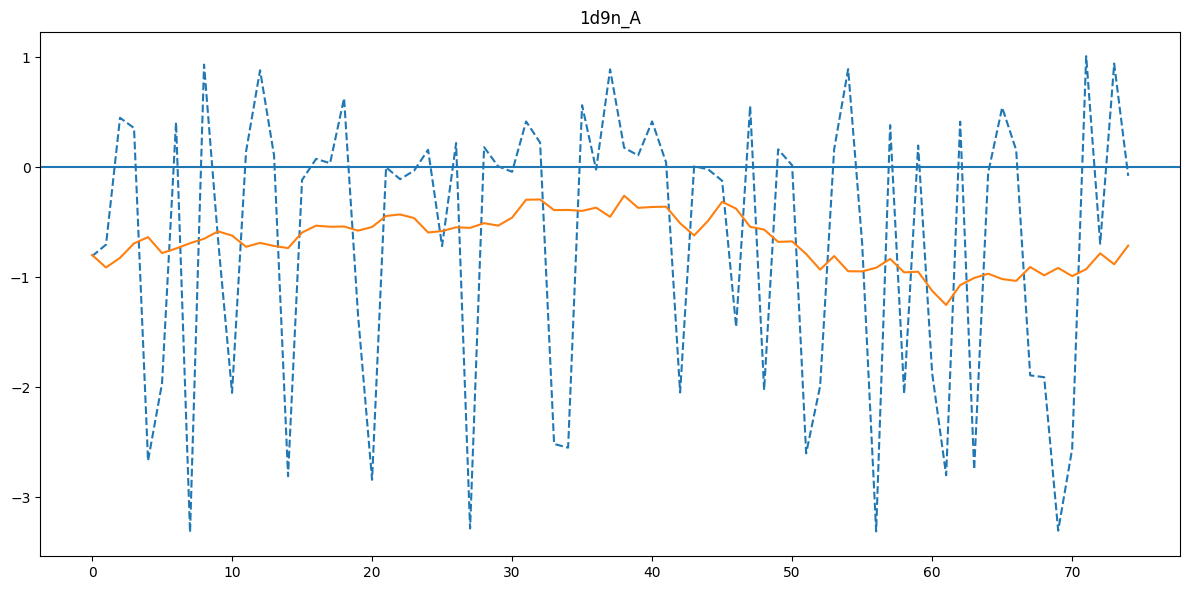

In [8]:
# IUPRED prediction


# Generate the prediction
pred, pred_smooth = iupred(seq)
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("{}_{}".format(PDB_ID, "A"))
ax.axhline()
ax.plot(np.arange(len(seq)), pred, ls='--')
ax.plot(np.arange(len(seq)), pred_smooth, ls='-')
plt.tight_layout()  # Remove figure padding
plt.savefig(PATH + '/iupred_{}_{}.png'.format(PDB_ID, "A"), dpi=300, bbox_inches='tight')


